In [22]:
# imports
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_columns', 500)  # For .info() method
pd.set_option('display.max_info_rows', 500)     # For .info() method
pd.set_option('display.width', None)            # No line wrapping
pd.set_option('display.max_colwidth', None)     # Full column names

import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [18]:
# Load and filter datasets
weekly_player_offense = pd.read_csv('../data/nfl-stats-1999-2022/versions/17/weekly_player_stats_offense.csv')
weekly_player_offense = weekly_player_offense[weekly_player_offense['season'].isin([2022, 2023, 2024])]

weekly_team_defense = pd.read_csv('../data/nfl-stats-1999-2022/versions/17/weekly_team_stats_defense.csv')
weekly_team_defense = weekly_team_defense[weekly_team_defense['season'].isin([2022, 2023, 2024])]

yearly_player_offense = pd.read_csv('../data/nfl-stats-1999-2022/versions/17/yearly_player_stats_offense.csv')
yearly_player_offense = yearly_player_offense[yearly_player_offense['season'].isin([2022, 2023, 2024])]

yearly_team_defense = pd.read_csv('../data/nfl-stats-1999-2022/versions/17/yearly_team_stats_defense.csv')
yearly_team_defense = yearly_team_defense[yearly_team_defense['season'].isin([2022, 2023, 2024])]

# Check what positions exist before filtering
print("Weekly player positions available:", weekly_player_offense['position'].unique())
print("Yearly player positions available:", yearly_player_offense['position'].unique())

# Filter to only fantasy-relevant positions
fantasy_positions = ['QB', 'RB', 'WR', 'TE', 'K']

# Filter player datasets to fantasy positions only
weekly_player_offense = weekly_player_offense[weekly_player_offense['position'].isin(fantasy_positions)]
yearly_player_offense = yearly_player_offense[yearly_player_offense['position'].isin(fantasy_positions)]

# Show the filtered results
print(f"\nFiltered weekly player offense: {len(weekly_player_offense)} rows")
print("Position distribution:", weekly_player_offense['position'].value_counts().sort_index())

print(f"\nFiltered yearly player offense: {len(yearly_player_offense)} rows") 
print("Position distribution:", yearly_player_offense['position'].value_counts().sort_index())

Weekly player positions available: ['QB' 'P' 'TE' 'WR' 'RB' 'FB' 'ILB' 'FS' 'SS' 'CB' 'OLB' 'DT' 'DE' 'MLB']
Yearly player positions available: ['QB' 'P' 'TE' 'WR' 'RB' 'FB' 'ILB' 'FS' 'SS' 'CB' 'OLB' 'DT' 'DE' 'MLB']

Filtered weekly player offense: 14877 rows
Position distribution: position
QB    1940
RB    3799
TE    3052
WR    6086
Name: count, dtype: int64

Filtered yearly player offense: 1720 rows
Position distribution: position
QB    252
RB    427
TE    353
WR    688
Name: count, dtype: int64


In [14]:
# Show dtypes/columns for each dataset:

print('Info for weekly_player_offense:\n', weekly_player_offense.info())
print('\nInfo for weekly_team_defense:\n', weekly_team_defense.info())
print('\nInfo for yearly_player_offense:\n', yearly_player_offense.info())
print('\nInfo for yearly_team_defense:\n', yearly_team_defense.info())

<class 'pandas.core.frame.DataFrame'>
Index: 15106 entries, 43523 to 58628
Data columns (total 393 columns):
 #    Column                                      Dtype  
---   ------                                      -----  
 0    season                                      int64  
 1    week                                        int64  
 2    offense_snaps                               float64
 3    offense_pct                                 float64
 4    team_offense_snaps                          float64
 5    player_id                                   object 
 6    birth_year                                  int64  
 7    draft_year                                  float64
 8    draft_round                                 float64
 9    draft_pick                                  float64
 10   draft_ovr                                   float64
 11   height                                      float64
 12   weight                                      float64
 13   college        

In [13]:
# Column exploration for fantasy football datasets


def explore_columns(df, dataset_name):
    """Explore and categorize columns in a dataset"""
    print(f"\n{'='*50}")
    print(f"EXPLORING {dataset_name.upper()}")
    print(f"{'='*50}")
    print(f"Total columns: {len(df.columns)}")
    
    # Get all columns
    cols = df.columns.tolist()
    
    # Categorize columns
    categories = defaultdict(list)
    
    for col in cols:
        col_lower = col.lower()
        
        # Fantasy scoring columns
        if any(term in col_lower for term in ['fantasy', 'ppr', 'standard', 'points']):
            categories['Fantasy Scoring'].append(col)
        
        # Player identification
        elif any(term in col_lower for term in ['player_id', 'player_name', 'position']):
            categories['Player ID'].append(col)
        
        # Basic stats
        elif any(term in col_lower for term in ['yards', 'yds', 'touchdown', 'td', 'rush', 'pass', 'rec']):
            categories['Basic Stats'].append(col)
        
        # Advanced/efficiency metrics
        elif any(term in col_lower for term in ['target', 'snap', 'pct', 'avg', 'per', 'rate']):
            categories['Advanced Metrics'].append(col)
        
        # Career/historical data
        elif any(term in col_lower for term in ['career', 'delta', 'rolling']):
            categories['Career/Trends'].append(col)
        
        # Game context
        elif any(term in col_lower for term in ['season', 'week', 'team', 'game']):
            categories['Game Context'].append(col)
        
        # Physical attributes
        elif any(term in col_lower for term in ['age', 'height', 'weight', 'draft']):
            categories['Player Attributes'].append(col)
        
        else:
            categories['Other'].append(col)
    
    # Display categories
    for category, column_list in categories.items():
        if column_list:  # Only show non-empty categories
            print(f"\n{category} ({len(column_list)} columns):")
            for i, col in enumerate(sorted(column_list)):
                if i < 10:  # Show first 10
                    print(f"  • {col}")
                elif i == 10:
                    print(f"  ... and {len(column_list) - 10} more")
                    break
    
    return categories

def find_fantasy_columns(df, dataset_name):
    """Specifically look for fantasy scoring columns"""
    print(f"\n🏆 FANTASY SCORING COLUMNS IN {dataset_name.upper()}:")
    print("-" * 50)
    
    fantasy_cols = [col for col in df.columns if any(term in col.lower() 
                    for term in ['fantasy', 'ppr', 'standard', '_points', 'ppg'])]
    
    if fantasy_cols:
        for col in fantasy_cols:
            print(f"  ✓ {col}")
    else:
        print("  ❌ No obvious fantasy scoring columns found")
    
    return fantasy_cols

def find_position_columns(df, dataset_name):
    """Look for position and player identification columns"""
    print(f"\n👤 PLAYER IDENTIFICATION IN {dataset_name.upper()}:")
    print("-" * 50)
    
    id_cols = [col for col in df.columns if any(term in col.lower() 
               for term in ['player', 'position', 'name', 'pos'])]
    
    for col in id_cols:
        print(f"  ✓ {col}")
        if 'position' in col.lower():
            unique_positions = df[col].unique() if col in df.columns else []
            print(f"    Positions: {unique_positions[:10]}...")  # Show first 10
    
    return id_cols

# Apply to your datasets
print("STARTING COLUMN EXPLORATION...")

# Explore weekly player offense
weekly_categories = explore_columns(weekly_player_offense, "Weekly Player Offense")
weekly_fantasy = find_fantasy_columns(weekly_player_offense, "Weekly Player Offense") 
weekly_id = find_position_columns(weekly_player_offense, "Weekly Player Offense")

# Explore yearly player offense  
yearly_categories = explore_columns(yearly_player_offense, "Yearly Player Offense")
yearly_fantasy = find_fantasy_columns(yearly_player_offense, "Yearly Player Offense")
yearly_id = find_position_columns(yearly_player_offense, "Yearly Player Offense")

print(f"\n{'='*60}")
print("SUMMARY FINDINGS")
print(f"{'='*60}")
print(f"Weekly Fantasy Columns Found: {len(weekly_fantasy)}")
print(f"Yearly Fantasy Columns Found: {len(yearly_fantasy)}")

STARTING COLUMN EXPLORATION...

EXPLORING WEEKLY PLAYER OFFENSE
Total columns: 393

Game Context (45 columns):
  • depth_team
  • games_played_season
  • season
  • season_average_fourth_down_converted
  • season_average_fourth_down_failed
  • season_average_fumble
  • season_average_fumble_forced
  • season_average_fumble_lost
  • season_average_fumble_not_forced
  • season_average_fumble_out_of_bounds
  ... and 35 more

Advanced Metrics (43 columns):
  • ayptarget
  • career_average_offense_snaps
  • career_average_targets
  • career_average_targets_gtg
  • career_average_targets_redzone
  • career_average_team_offense_snaps
  • career_comp_pct
  • career_int_pct
  • career_offense_snaps
  • career_targets
  ... and 33 more

Player ID (3 columns):
  • player_id
  • player_name
  • position

Other (27 columns):
  • adot
  • birth_year
  • college
  • conference
  • division
  • fourth_down_converted
  • fourth_down_failed
  • fumble
  • fumble_forced
  • fumble_lost
  ... and 17 more


In [20]:
# First, let's see what fantasy scoring columns we have
fantasy_cols = [col for col in weekly_player_offense.columns if 'fantasy' in col.lower() or 'ppr' in col.lower() or 'standard' in col.lower()]
print("Fantasy scoring columns available:")
for col in fantasy_cols:
    print(f"  {col}")

# Focus on the main fantasy point columns
ppr_col = 'fantasy_points_ppr'
std_col = 'fantasy_points_standard'

# Basic summary statistics by position
print(f"\nPPR Fantasy Points Summary by Position:")
print(weekly_player_offense.groupby('position')[ppr_col].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(2))

print(f"\nStandard Fantasy Points Summary by Position:")  
print(weekly_player_offense.groupby('position')[std_col].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(2))

Fantasy scoring columns available:
  fantasy_points_ppr
  fantasy_points_standard
  delta_fantasy_points_ppr
  delta_fantasy_points_standard
  season_fantasy_points_ppr
  season_fantasy_points_standard
  career_fantasy_points_ppr
  career_fantasy_points_standard
  season_average_fantasy_points_ppr
  career_average_fantasy_points_ppr
  season_average_fantasy_points_standard
  career_average_fantasy_points_standard
  season_average_ppr_ppg
  season_average_standard_ppg
  career_average_ppr_ppg
  career_average_standard_ppg

PPR Fantasy Points Summary by Position:
          count   mean  median    std   min    max
position                                          
QB         1940  15.81   15.44  10.68 -5.44  57.88
RB         3799   8.99    7.00   7.99 -3.00  55.10
TE         3052   6.06    4.10   5.96 -2.00  40.52
WR         6086   8.30    6.20   7.81 -4.50  55.40

Standard Fantasy Points Summary by Position:
          count   mean  median    std   min    max
position                     

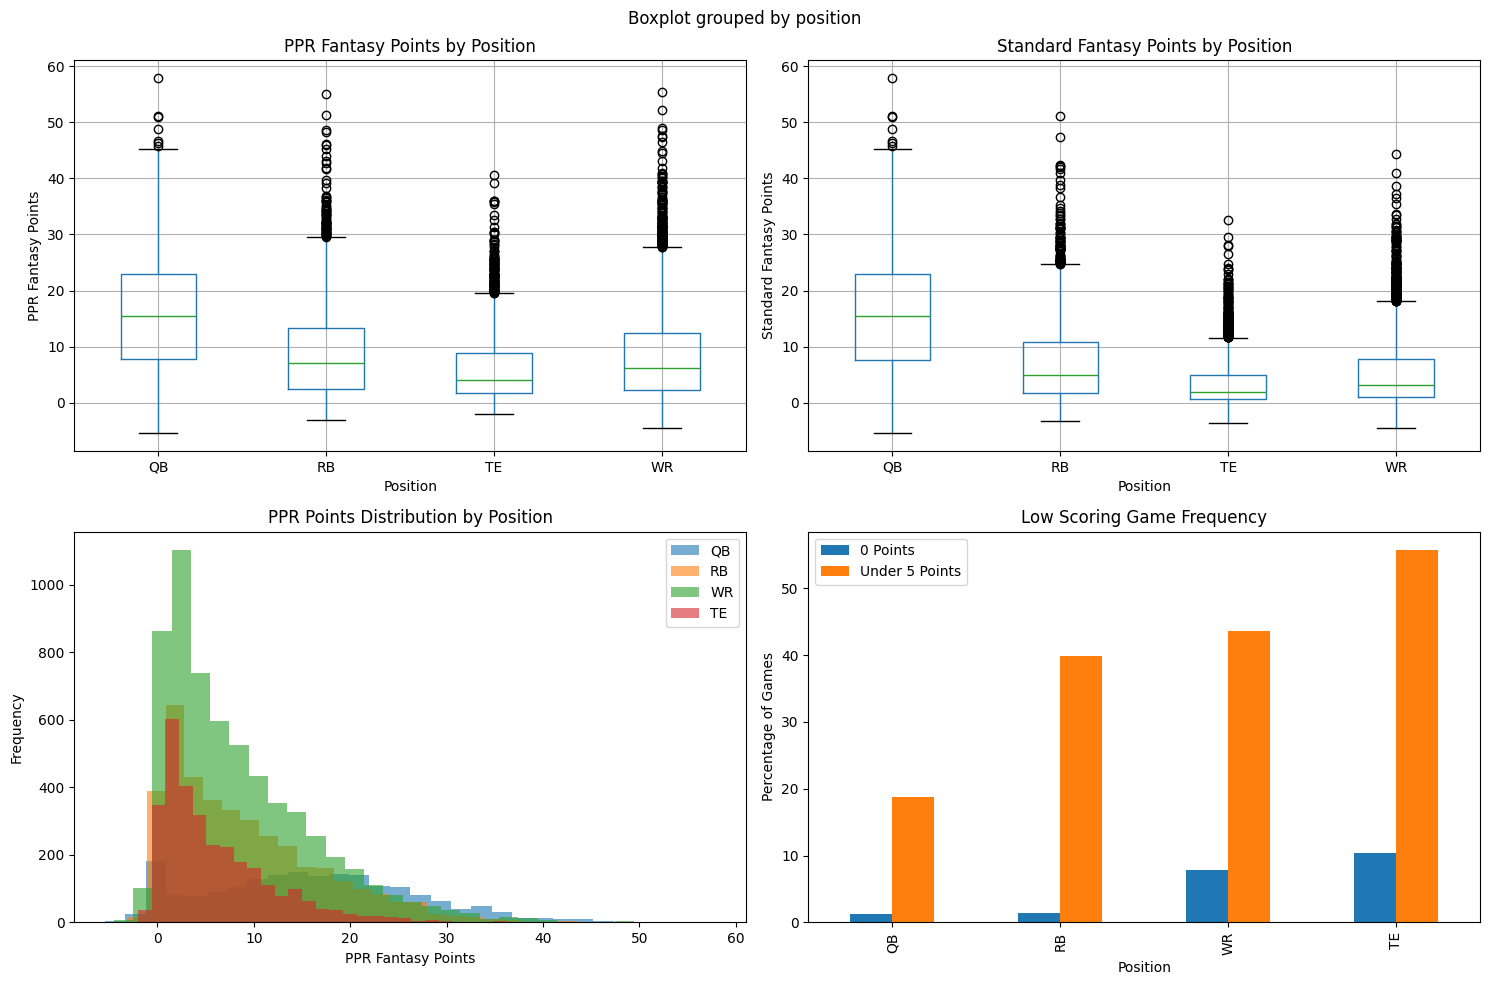


Low scoring game analysis:
  Position  Zero_Points_%  Under_5_Points_%
0       QB           1.29             18.81
1       RB           1.42             39.83
2       WR           7.85             43.56
3       TE          10.32             55.70


In [21]:
# Create visualizations of fantasy point distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# PPR boxplot by position
weekly_player_offense.boxplot(column=ppr_col, by='position', ax=axes[0,0])
axes[0,0].set_title('PPR Fantasy Points by Position')
axes[0,0].set_xlabel('Position') 
axes[0,0].set_ylabel('PPR Fantasy Points')

# Standard boxplot by position
weekly_player_offense.boxplot(column=std_col, by='position', ax=axes[0,1])
axes[0,1].set_title('Standard Fantasy Points by Position')
axes[0,1].set_xlabel('Position')
axes[0,1].set_ylabel('Standard Fantasy Points')

# PPR histogram by position
for pos in ['QB', 'RB', 'WR', 'TE']:
    pos_data = weekly_player_offense[weekly_player_offense['position'] == pos][ppr_col]
    axes[1,0].hist(pos_data, alpha=0.6, label=pos, bins=30)
axes[1,0].set_title('PPR Points Distribution by Position')
axes[1,0].set_xlabel('PPR Fantasy Points')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()

# Zero/low scoring analysis
zero_low_data = []
for pos in ['QB', 'RB', 'WR', 'TE']:
    pos_df = weekly_player_offense[weekly_player_offense['position'] == pos]
    zero_pct = (pos_df[ppr_col] == 0).mean() * 100
    low_pct = (pos_df[ppr_col] < 5).mean() * 100
    zero_low_data.append([pos, zero_pct, low_pct])

zero_low_df = pd.DataFrame(zero_low_data, columns=['Position', 'Zero_Points_%', 'Under_5_Points_%'])
zero_low_df.set_index('Position').plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Low Scoring Game Frequency')
axes[1,1].set_ylabel('Percentage of Games')
axes[1,1].legend(['0 Points', 'Under 5 Points'])

plt.tight_layout()
plt.show()

# Show the zero/low scoring data
print("\nLow scoring game analysis:")
print(zero_low_df.round(2))

In [23]:
# Get numeric columns only (for correlation analysis)
numeric_cols = weekly_player_offense.select_dtypes(include=[np.number]).columns

# Calculate correlations with PPR fantasy points
target_col = 'fantasy_points_ppr'
correlations = weekly_player_offense[numeric_cols].corr()[target_col].abs().sort_values(ascending=False)

# Remove the target variable itself
correlations = correlations.drop(target_col, errors='ignore')

print(f"Top 20 features correlated with {target_col}:")
print("-" * 60)
for feature, corr in correlations.head(20).items():
    print(f"{feature:<50} {corr:.3f}")

# Check for very high correlations (potential redundancy)
print(f"\nHighly correlated features (>0.8):")
high_corr_features = correlations[correlations > 0.8]
for feature, corr in high_corr_features.items():
    print(f"{feature:<50} {corr:.3f}")

Top 20 features correlated with fantasy_points_ppr:
------------------------------------------------------------
fantasy_points_standard                            0.962
total_tds                                          0.790
season_average_fantasy_points_ppr                  0.759
season_average_ppr_ppg                             0.759
total_yards                                        0.753
season_average_fantasy_points_standard             0.728
season_average_standard_ppg                        0.728
pass_touchdown                                     0.701
delta_total_tds                                    0.673
first_down_pass                                    0.650
season_total_tds                                   0.639
season_average_total_tds                           0.639
team_pass_touchdown_share                          0.630
yards_after_catch                                  0.623
touches                                            0.617
career_average_ppr_ppg          

### Based off what was found from above, the method I would like to take is to **create separate models based on position**. That way, in the app, I can pick a particular position to draft and utilize that model at that time.

I will use the yearly datasets first, and possibly add granularity with the weekly datasets if needed.